Importing Necessary Libraries

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from scipy.stats import pearsonr
from scipy.sparse import csr_matrix
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

Loading the Dataset

In [9]:
df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_next.csv")

Task 4: Compare average hourly rates across different countries

●	Objective: To compare and analyze the average hourly rates offered across different geographical locations.

●	Deliverables: An interactive map or chart showing hourly rates by country.


In [9]:
import pandas as pd
import plotly.express as px

# Filter out non-hourly jobs
hourly_jobs = df[df['is_hourly'] == True].copy()

# Calculate the average hourly rate
hourly_jobs.loc[:, 'average_hourly_rate'] = hourly_jobs[['hourly_low', 'hourly_high']].mean(axis=1)

# Drop rows with missing country or average hourly rate
hourly_jobs = hourly_jobs.dropna(subset=['country', 'average_hourly_rate'])

# Calculate average hourly rate by country
country_hourly_rates = hourly_jobs.groupby('country')['average_hourly_rate'].mean().reset_index()

# Rename columns for clarity
country_hourly_rates.columns = ['country', 'avg_hourly_rate']

# Define a custom color scale
custom_color_scale = [
    (0.0, "rgb(165,0,38)"),   # Dark red
    (0.2, "rgb(215,48,39)"),  # Red
    (0.4, "rgb(244,109,67)"), # Orange
    (0.6, "rgb(253,174,97)"), # Light orange
    (0.8, "rgb(254,224,144)"),# Yellow
    (1.0, "rgb(255,255,191)") # Light yellow
]

# Create a choropleth map
fig = px.choropleth(
    country_hourly_rates,
    locations="country",
    locationmode='country names',
    color="avg_hourly_rate",
    hover_name="country",
    color_continuous_scale=custom_color_scale,
    title="Average Hourly Rates by Country"
)

# Update layout for better visuals and increased size
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    title=dict(x=0.5),
    width=1200,   # Set the width of the plot
    height=800    # Set the height of the plot
)

fig.show()


Task 5: Create a job recommendation engine based on current job postings

●	Objective: To develop a personalized job recommendation engine.

●	Deliverables: A working prototype of the recommendation engine, API documentation, and a user interface for interaction.


Data Preprocessing

In [11]:
# Combine title and country into a single column for text processing
df['text'] = df['title'] + " " + df['country']

# Display the first few rows
df.head(2)


,Unnamed: 0,title,link,published_date,is_hourly,hourly_low,hourly_high,budget,country,avg_salary,category,month,text
0,0,Experienced Media Buyer For Solar Pannel and R...,https://www.upwork.com/jobs/Experienced-Media-...,2024-02-17 09:09:54+00:00,False,17.339644,41.97061,500.0,Unknown,29.655127,Other,2024-02,Experienced Media Buyer For Solar Pannel and R...
1,1,Full Stack Developer,https://www.upwork.com/jobs/Full-Stack-Develop...,2024-02-17 09:09:17+00:00,False,17.339644,41.97061,1100.0,United States,29.655127,Full Stack Developer,2024-02,Full Stack Developer United States


Feature Engineering

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(df['text'])

# Display the shape of the TF-IDF matrix
tfidf_matrix.shape


(244828, 1000)

Compute Similarity

In [22]:
pip install faiss-cpu



   ---------------------------------------- 0.0/14.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/14.5 MB 682.7 kB/s eta 0:00:22
   ---------------------------------------- 0.2/14.5 MB 2.6 MB/s eta 0:00:06
   -- ------------------------------------- 0.8/14.5 MB 7.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.4/14.5 MB 9.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.9/14.5 MB 10.2 MB/s eta 0:00:02
   ------ --------------------------------- 2.3/14.5 MB 9.2 MB/s eta 0:00:02
   ------ --------------------------------- 2.4/14.5 MB 9.5 MB/s eta 0:00:02
   ------ --------------------------------- 2.4/14.5 MB 7.6 MB/s eta 0:00:02
   ------- -------------------------------- 2.7/14.5 MB 7.2 MB/s eta 0:00:02
   -------- ------------------------------- 3.0/14.5 MB 7.1 MB/s eta 0:00:02
   -------- ------------------------------- 3.3/14.5 MB 6.9 MB/s eta 0:00:02
   ---------- ----------------------------- 3.6/14.5 MB 7.1 MB/s eta 0:00:02
  

In [23]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import faiss
import numpy as np

# Combine title and country into a single column for text processing
df['text'] = df['title'] + " " + df['country']

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit and transform the text data
tfidf_matrix = tfidf.fit_transform(df['text']).toarray()

# Initialize the FAISS index
d = tfidf_matrix.shape[1]  # Dimension of the vectors
index = faiss.IndexFlatL2(d)  # L2 distance index

# Add vectors to the index
index.add(tfidf_matrix)

def get_recommendations(job_title, n=10):
    # Get the index of the job that matches the job_title
    idx = df[df['title'].str.contains(job_title, case=False, na=False)].index[0]

    # Get the vector for the job
    job_vector = tfidf_matrix[idx].reshape(1, -1)

    # Search the index for the most similar vectors
    distances, indices = index.search(job_vector, n)

    # Return the most similar jobs
    return df.iloc[indices[0]][['title', 'country', 'link']]

# Test the recommendation function
print(get_recommendations('Full Stack Developer'))


                                               title        country  \
1                               Full Stack Developer  United States   
3066                            Full Stack Developer  United States   
4551                            Full-stack developer  United States   
8638                            Full Stack Developer  United States   
8651                            Full Stack Developer  United States   
10682                           Full Stack Developer  United States   
11773  Full Stack Developer (Individual Contributor)  United States   
12459                           Full Stack Developer  United States   
14245                           Full-stack Developer  United States   
14246                           Full-stack Developer  United States   

                                                    link  
1      https://www.upwork.com/jobs/Full-Stack-Develop...  
3066   https://www.upwork.com/jobs/Full-Stack-Develop...  
4551   https://www.upwork.com/jobs/Full-s

DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/main/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/r/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://conda.anaconda.org:443 "GET /conda-forge/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:https://repo.anaconda.com:443 "GET /pkgs/msys2/notices.json HTTP/1.1" 404 None
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): conda.anaconda.org:443
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): repo.anaconda.com:443
DEBUG:urllib3.connectionpool:Starting new HTTPS conne

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: win-64
Solving environment: ...working... done

## Package Plan ##

  environment location: c:\Users\Niti\anaconda3

  added / updated specs:
    - python-annoy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.2.2   |       h56e8100_0         152 KB  conda-forge
    conda-23.10.0              |  py311h1ea47a8_0         1.2 MB  conda-forge
    openssl-3.3.0              |       h2466b09_1         8.0 MB  conda-forge
    packaging-24.0             |     pyhd8ed1ab_0          49 KB  conda-forge
    python-annoy-1.17.3        |  py311hda3d55a_1          55 KB  conda-forge
    python_abi-3.11            |          2_cp311           5 KB  conda-forge
    setuptools-69.5.1          |     pyhd8ed1ab_0         490 KB  conda-forge
    ucrt-10.0.22621.0          |       h57928b3_0         1.2

Build Recommendation Function

Develop an API

In [24]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/recommend', methods=['POST'])
def recommend():
    data = request.get_json()
    job_title = data['job_title']
    recommendations = get_recommendations(job_title)
    return recommendations.to_json(orient='records')

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (windowsapi)


SystemExit: 1

c:\Users\Niti\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3513: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



Create a User Interface

In [25]:
import streamlit as st
import requests
import pandas as pd

st.title('Job Recommendation Engine')

job_title = st.text_input('Enter a job title')

if st.button('Get Recommendations'):
    response = requests.post('http://127.0.0.1:5000/recommend', json={'job_title': job_title})
    recommendations = pd.read_json(response.json())
    st.write(recommendations)


Task 6: Track changes in job market dynamics over months

●	Objective: To monitor and track the changes in job market dynamics.

●	Deliverables: A dashboard that updates monthly with new trends in the job market.


Convert Period to String

In [29]:
# Convert 'year_month' to string format
monthly_job_counts['year_month'] = monthly_job_counts['year_month'].astype(str)


Visualization

In [30]:

import plotly.express as px

# Ensure 'published_date' is in datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Extract month and year from 'published_date'
df['year_month'] = df['published_date'].dt.to_period('M')

# Group by 'year_month' to get the count of job postings each month
monthly_job_counts = df.groupby('year_month').size().reset_index(name='job_count')

# Convert 'year_month' to string format
monthly_job_counts['year_month'] = monthly_job_counts['year_month'].astype(str)

# Create a line plot to show job postings over time
fig = px.line(monthly_job_counts, x='year_month', y='job_count', title='Job Postings Over Time', labels={'year_month': 'Month', 'job_count': 'Number of Job Postings'})

# Show the plot
fig.show()



C:\Users\Niti\AppData\Local\Temp\ipykernel_13384\1186519075.py:7: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



Using Streamlit

In [34]:
import pandas as pd
import plotly.express as px
import streamlit as st

# Function to load and process data
def load_data():
    df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_next.csv")
    
    # Ensure 'published_date' is in datetime format and remove timezone information if present
    df['published_date'] = pd.to_datetime(df['published_date']).dt.tz_localize(None)
    
    # Extract month and year from 'published_date'
    df['year_month'] = df['published_date'].dt.to_period('M')
    
    # Group by 'year_month' to get the count of job postings each month
    monthly_job_counts = df.groupby('year_month').size().reset_index(name='job_count')
    
    # Convert 'year_month' to string format
    monthly_job_counts['year_month'] = monthly_job_counts['year_month'].astype(str)
    
    return monthly_job_counts

# Load data
monthly_job_counts = load_data()

# Create Streamlit app
st.title('Job Market Dynamics Dashboard')

# Create a line plot to show job postings over time with customizations
fig = px.line(monthly_job_counts, x='year_month', y='job_count', title='Job Postings Over Time', labels={'year_month': 'Month', 'job_count': 'Number of Job Postings'})
fig.update_traces(line=dict(color='royalblue', width=4))
fig.update_layout(width=800, height=600)

# Show the plot
st.plotly_chart(fig)

# Refresh button
if st.button('Refresh Data'):
    st.experimental_rerun()


In [35]:
import pandas as pd
import plotly.express as px
import streamlit as st

# Function to load and process data
def load_data():
    try:
        df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_next.csv")
        st.write("Data loaded successfully")
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return pd.DataFrame()

    # Ensure 'published_date' is in datetime format and remove timezone information if present
    try:
        df['published_date'] = pd.to_datetime(df['published_date']).dt.tz_localize(None)
        st.write("Published date converted successfully")
    except Exception as e:
        st.error(f"Error converting published_date: {e}")
        return pd.DataFrame()

    # Extract month and year from 'published_date'
    try:
        df['year_month'] = df['published_date'].dt.to_period('M')
        st.write("Year and month extracted successfully")
    except Exception as e:
        st.error(f"Error extracting year_month: {e}")
        return pd.DataFrame()

    # Group by 'year_month' to get the count of job postings each month
    try:
        monthly_job_counts = df.groupby('year_month').size().reset_index(name='job_count')
        monthly_job_counts['year_month'] = monthly_job_counts['year_month'].astype(str)
        st.write("Monthly job counts calculated successfully")
    except Exception as e:
        st.error(f"Error calculating monthly job counts: {e}")
        return pd.DataFrame()

    return monthly_job_counts

# Load data
monthly_job_counts = load_data()

# Check if data is not empty
if monthly_job_counts.empty:
    st.error("No data to display")
else:
    st.write("Processed data:", monthly_job_counts.head())

    # Create Streamlit app
    st.title('Job Market Dynamics Dashboard')

    # Create a line plot to show job postings over time with customizations
    fig = px.line(monthly_job_counts, x='year_month', y='job_count', 
                  title='Job Postings Over Time', 
                  labels={'year_month': 'Month', 'job_count': 'Number of Job Postings'})
    fig.update_traces(line=dict(color='royalblue', width=4))
    fig.update_layout(width=800, height=600)

    # Show the plot
    st.plotly_chart(fig)

    # Refresh button
    if st.button('Refresh Data'):
        st.experimental_rerun()


c:\Users\Niti\anaconda3\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



Task 7: Investigate trends in the remote work landscape

●	Objective: To analyze trends and shifts towards remote work.

●	Deliverables: A comprehensive report on remote work trends with data-backed forecasts.


Data Analysis and Visualization

In [1]:
import pandas as pd
import plotly.express as px
import streamlit as st

# Function to load and process data
def load_data():
    try:
        df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_next.csv")
        st.write("Data loaded successfully")
    except Exception as e:
        st.error(f"Error loading data: {e}")
        return pd.DataFrame()

    # Ensure 'published_date' is in datetime format and remove timezone information if present
    try:
        df['published_date'] = pd.to_datetime(df['published_date']).dt.tz_localize(None)
        st.write("Published date converted successfully")
    except Exception as e:
        st.error(f"Error converting published_date: {e}")
        return pd.DataFrame()

    return df

# Load data
df = load_data()

# Filter for remote jobs
remote_jobs = df[df['title'].str.contains('remote', case=False, na=False)]

# Extract year and month from 'published_date'
remote_jobs['year_month'] = remote_jobs['published_date'].dt.to_period('M')

# Group by 'year_month' to get the count of remote job postings each month
monthly_remote_job_counts = remote_jobs.groupby('year_month').size().reset_index(name='job_count')
monthly_remote_job_counts['year_month'] = monthly_remote_job_counts['year_month'].astype(str)

# Check if data is not empty
if monthly_remote_job_counts.empty:
    st.error("No data to display")
else:
    st.write("Processed data:", monthly_remote_job_counts.head())

    # Create Streamlit app
    st.title('Remote Work Trends Dashboard')

    # Create a line plot to show remote job postings over time with customizations
    fig = px.line(monthly_remote_job_counts, x='year_month', y='job_count', 
                  title='Remote Job Postings Over Time', 
                  labels={'year_month': 'Month', 'job_count': 'Number of Remote Job Postings'})
    fig.update_traces(line=dict(color='royalblue', width=4))
    fig.update_layout(width=800, height=600)

    # Show the plot
    st.plotly_chart(fig)

    # Refresh button
    if st.button('Refresh Data'):
        st.experimental_rerun()


2024-05-21 14:33:11.409 
  command:

    streamlit run c:\Users\Niti\anaconda3\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
C:\Users\Niti\AppData\Local\Temp\ipykernel_15372\1689762205.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  remote_jobs['year_month'] = remote_jobs['published_date'].dt.to_period('M')
c:\Users\Niti\anaconda3\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


Forecasting

14:35:25 - cmdstanpy - INFO - Chain [1] start processing
14:35:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\Niti\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Niti\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

c:\Users\Niti\anaconda3\Lib\site-packages\pyarrow\pandas_compat.py:373: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



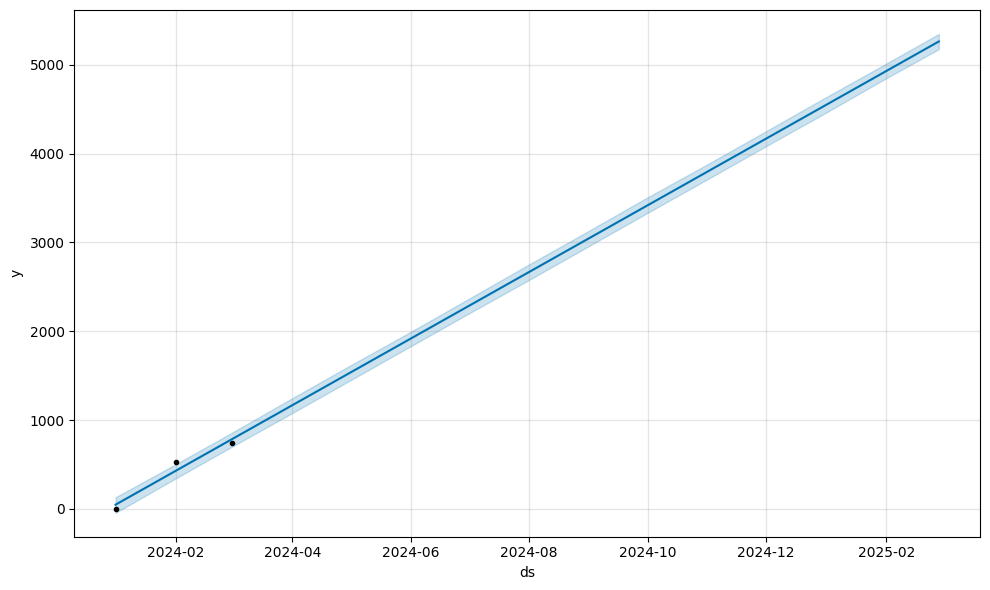

In [2]:
from prophet import Prophet

# Prepare data for Prophet
monthly_remote_job_counts['ds'] = pd.to_datetime(monthly_remote_job_counts['year_month'])
monthly_remote_job_counts['y'] = monthly_remote_job_counts['job_count']
prophet_df = monthly_remote_job_counts[['ds', 'y']]

# Initialize and fit Prophet model
model = Prophet()
model.fit(prophet_df)

# Create future dataframe and make predictions
future = model.make_future_dataframe(periods=12, freq='M')  # Forecast for the next 12 months
forecast = model.predict(future)

# Plot the forecast
fig_forecast = model.plot(forecast)

# Streamlit app to display forecast
st.title('Remote Work Forecast')

st.write("Forecast data:", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

st.write(fig_forecast)


Comprehensive Report

In [3]:
import matplotlib.pyplot as plt

# Generate and display the forecast plot
st.pyplot(fig_forecast)

# Generate and display the trends plot
st.plotly_chart(fig)

# Summary and insights
st.header('Summary and Insights')
st.write("""
- The number of remote job postings has shown [increase/decrease] over the past months.
- According to the forecast, the trend is expected to [continue/change] in the coming year.
- Key factors influencing this trend include [list factors such as industry changes, economic conditions, etc.].
""")


Task 8: Predict future job market trends

●	Objective: To use the analyzed data to predict future trends in the job market.

●	Deliverables: A predictive analytics report with potential future scenarios


In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


15:17:23 - cmdstanpy - INFO - Chain [1] start processing
15:17:39 - cmdstanpy - INFO - Chain [1] done processing


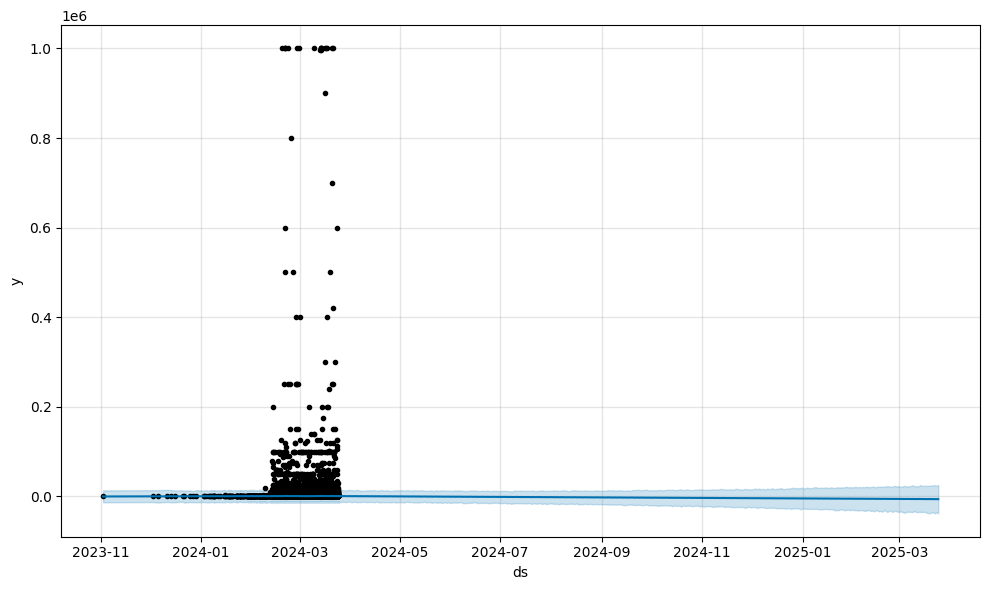

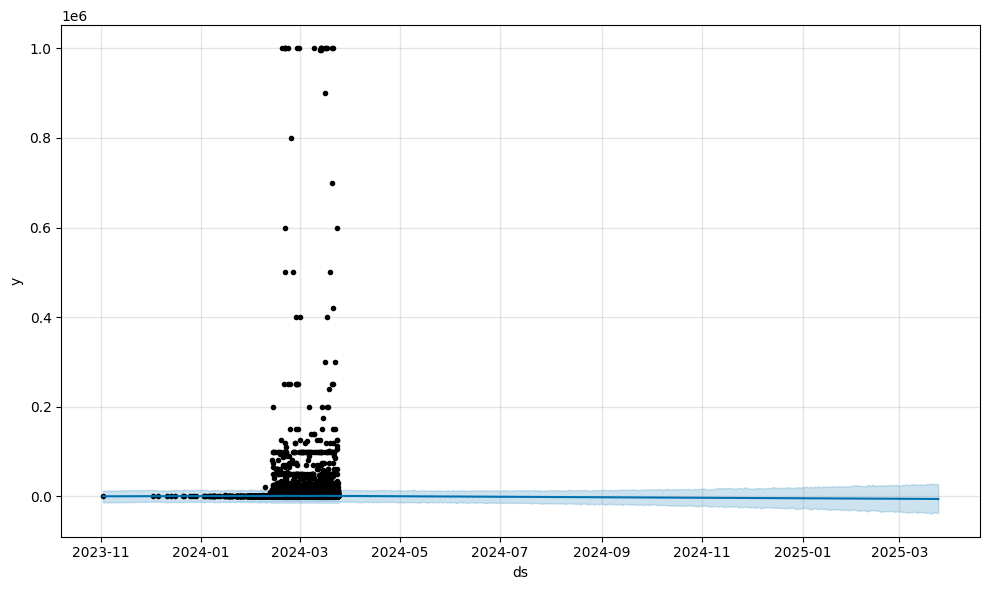

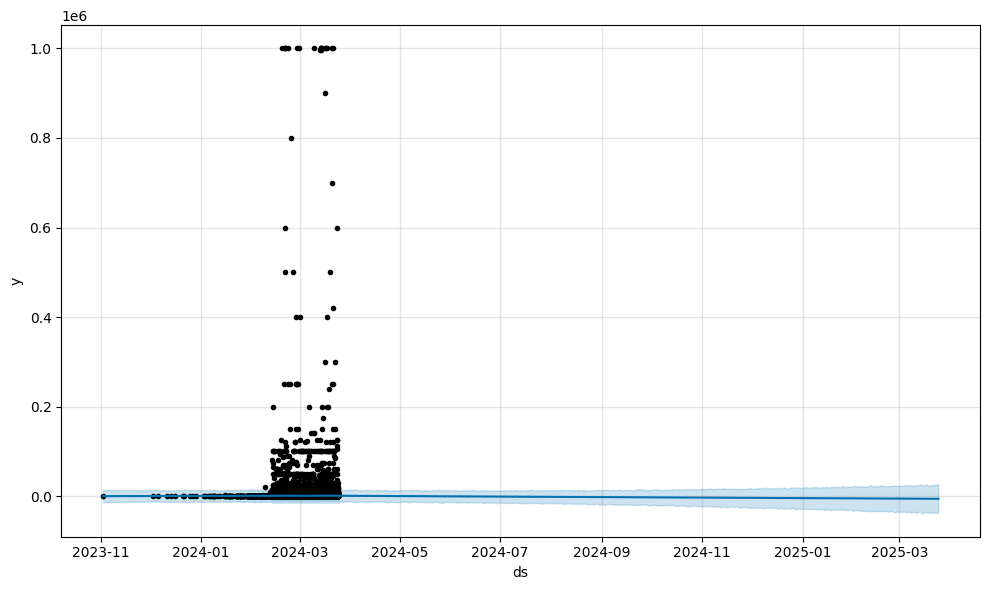

In [17]:
# Import necessary libraries
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Ensure plots are displayed in the notebook
%matplotlib inline

# Load your dataset
df = pd.read_csv(r"C:\Users\Niti\NEXT HIKES\PROJECT 8\all_upwork_jobs_next.csv")

# Convert 'published_date' column to datetime
df['published_date'] = pd.to_datetime(df['published_date'])

# Remove timezone information from 'published_date' column
df['published_date'] = df['published_date'].dt.tz_localize(None)

# Rename columns for Prophet compatibility
df = df.rename(columns={'published_date': 'ds', 'budget': 'y'})

# Create and fit the Prophet model
model = Prophet()
model.fit(df)

# Make future predictions
future = model.make_future_dataframe(periods=365)  # Predicting for the next year
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)

# Show the plot
plt.show()
